In [2]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import time
from sklearn.metrics import mean_squared_error
import datetime
from scipy.special import stdtr
plt.rcParams["figure.figsize"]=(10,8)

### Question 1




slope: 0.09324142754349966 p-value 0.6409049000031651 std_err 0.1997058644355541 intercept: 0.004047837686662456 r_value: 0.026551295701909915


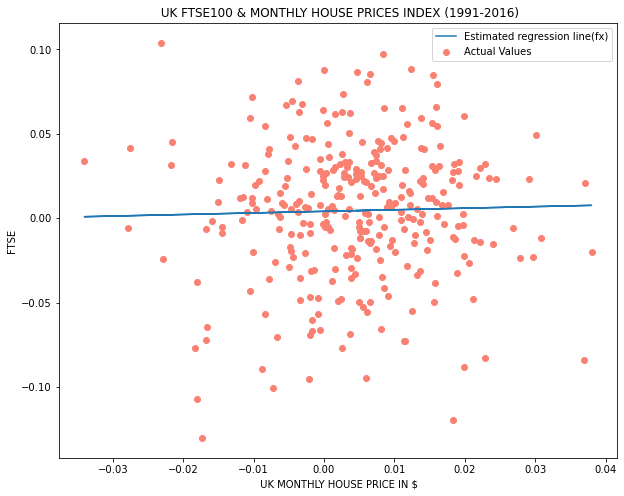

In [4]:
#Null Hypothesis:H0: There IS NOT a significant linear relationship(correlation) between x and y in the population
#Alternate Hypothesis:H1:There IS A SIGNIFICANT LINEAR RELATIONSHIP (correlation) between x and y in the population


#housing data
housing = pd.read_excel("HPI_Monthly.xls", index_col=0)
housing_data = housing[["Average House Price"]]
housing_data  = housing_data.rename({"Average House Price":"Average_Price"},axis = "columns")
housing_data  = housing_data.iloc[:312,:]


#FTSE data
FTSE = pd.read_csv("FTSE100.csv")
FTSE["Date"] = pd.to_datetime(FTSE.Date)
FTSE.set_index("Date", inplace = True)
FTSE.sort_values(by=['Date'], inplace=True, ascending=True)
ftse_data = FTSE[["Adj Close"]]
ftse_data = ftse_data.rename({"Adj Close":"AdjClose"}, axis = "columns")

#monthly return
ftse_data["Month_Closing"] = ftse_data["AdjClose"]/ftse_data["AdjClose"].shift(1)-1
housing_data["Month_Closing"] = housing_data["Average_Price"]/housing_data["Average_Price"].shift(1)-1
housing_data.dropna(inplace=True)
ftse_data.dropna(inplace=True)



#calculating linear regression
print("\n")
slope, intercept, r_value, p_value, std_err = stats.linregress(housing_data.Month_Closing,ftse_data.Month_Closing)
print("slope:",slope, "p-value",p_value ,"std_err", std_err, "intercept:", intercept,"r_value:", r_value)

#data to plot regression line
reg_line = (slope * housing_data.Month_Closing) + intercept 

#plotting scatter
plt.scatter(housing_data.Month_Closing,ftse_data.Month_Closing, color = "salmon", label = "Actual Values")
plt.plot(housing_data.Month_Closing, reg_line, label = "Estimated regression line(fx)")
#plt.plot(x_test,y_predicted)
plt.gca().update(dict(title=" UK FTSE100 & MONTHLY HOUSE PRICES INDEX (1991-2016)",xlabel=" UK MONTHLY HOUSE PRICE IN $",ylabel="FTSE"))
plt.legend()
plt.show()





In [5]:
#correlation coefficient
print("Pearsons correlation: %.4f" %r_value)

#hypothesis testing
print("The Pvalue is {:.4f}".format(p_value))

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Accept the null hypothesis")

Pearsons correlation: 0.0266
The Pvalue is 0.6409
Accept the null hypothesis


### Question 2

In [6]:
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
College = pd.read_excel("College.csv")
College.rename( columns={'Unnamed: 0':'CollegeName'}, inplace=True )

#dataset as variables
x = College[["Apps","Enroll","Outstate","Top10perc","Top25perc"]]
y = College[["Grad.Rate"]]

#stepwise backward correlation
def backward_regression(X, y,threshold_out,verbose=False):
    included=list(X.columns)
    
    while True:
        changed=False
        df_model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = df_model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
                
        if not changed:
            
            break
            
    return included

#backward stepwise regression

useful_vars = backward_regression(x,y,threshold_out=0.05,verbose=True)

print("Backward stepwise generated useful variables for prediction are:",useful_vars)

print("\n")

#BIC using Lasso
bic_regression = linear_model.LassoLarsIC(criterion='bic', normalize=False)
bic_regression.fit(x,y)

print(bic_regression.coef_)



#MAPE accuracy using all features
def mean_absolute_percentage_error(q, q_pred): 
    q, q_pred = np.array(q), np.array(q_pred)
    return np.mean(np.abs((q - q_pred) / q)) * 100
p = x
q = y
q_pred = bic_regression.predict(p)

mape_result = mean_absolute_percentage_error(q,q_pred)
print("\n")
print("MAPE score using all 5 features : ",mape_result)

#MAPE accuracy using backward stepwise useful feature
a = College[["Apps","Enroll","Outstate","Top25perc"]]
b = College[["Grad.Rate"]]

bic2_regression = linear_model.LassoLarsIC(criterion='bic', normalize=False)
bic2_regression.fit(a,b)

def mean_absolute_percentage_error(t, t_pred): 
    t, t_pred = np.array(t), np.array(t_pred)
    return np.mean(np.abs((t - t_pred) / t)) * 100
s = a
t = b
t_pred = bic2_regression.predict(s)

mape_result2 = mean_absolute_percentage_error(t,t_pred)

print("\n")
print("MAPE score using backward stepwise useful features: ",mape_result2)

#MAPE accuracy using BIC useful feature
z = College[["Apps","Enroll","Outstate","Top10perc"]]
y = College[["Grad.Rate"]]

bic3_regression = linear_model.LassoLarsIC(criterion='bic', normalize=False)
bic3_regression.fit(z,y)

def mean_absolute_percentage_error(t, t_pred): 
    t, t_pred = np.array(t), np.array(t_pred)
    return np.mean(np.abs((t - t_pred) / t)) * 100
s = z
t = y
t_pred = bic3_regression.predict(s)

mape_result3 = mean_absolute_percentage_error(t,t_pred)

print("\n")
print("MAPE score using BIC best features : ",mape_result3)

#CMU prediction
CMU = College[College["CollegeName"] == "Carnegie Mellon University"]
CMU_values = CMU[["Apps","Enroll","Outstate","Top10perc"]]

CMU_gradrate = bic3_regression.predict(CMU_values)
print("CMU graduation rate is:",CMU_gradrate)

Drop Top10perc                      with p-value 0.446344
Backward stepwise generated useful variables for prediction are: ['Apps', 'Enroll', 'Outstate', 'Top25perc']


[ 0.00082806 -0.00293584  0.00186158  0.          0.17922103]


MAPE score using all 5 features :  29.31197418109906


MAPE score using backward stepwise useful features:  29.4263004020622


MAPE score using BIC best features :  29.274957446567957
CMU graduation rate is: [89.082926]


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [7]:
#correlation
College_data = College[["Apps","Enroll","Outstate","Top10perc","Top25perc","Grad.Rate"]]
feature=list(["Apps","Enroll","Outstate","Top10perc","Top25perc","Grad.Rate"])
College_data[feature].corr()


,Apps,Enroll,Outstate,Top10perc,Top25perc,Grad.Rate
Apps,1.000000,0.846822,0.050159,0.338834,0.351640,0.146755
Enroll,0.846822,1.000000,-0.155477,0.181294,0.226745,-0.022341
Outstate,0.050159,-0.155477,1.000000,0.562331,0.489394,0.571290
Top10perc,0.338834,0.181294,0.562331,1.000000,0.891995,0.494989
Top25perc,0.351640,0.226745,0.489394,0.891995,1.000000,0.477281
Grad.Rate,0.146755,-0.022341,0.571290,0.494989,0.477281,1.000000


In [8]:
def get_stats(x):
    x = College[["Apps","Enroll","Outstate","Top10perc","Top25perc"]]
    results = sm.OLS(y, x).fit()
    print(results.summary())

get_stats(College)



                                 OLS Regression Results                                
Dep. Variable:              Grad.Rate   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              2707.
Date:                Thu, 21 Oct 2021   Prob (F-statistic):                        0.00
Time:                        20:37:05   Log-Likelihood:                         -3243.1
No. Observations:                 777   AIC:                                      6496.
Df Residuals:                     772   BIC:                                      6519.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Question 3

Pearsons correlation: -0.051


2021 predicted values are GDP: [[49.21822527]]  Air Freight:  [[63.41110067]]


slope: -0.01986101852061476 p-value 0.8298008337934937 std_err 0.09106172318718633 intercept: 64.38862475299034 r_value: -0.05134004996723577


Reject the null hypothesis


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


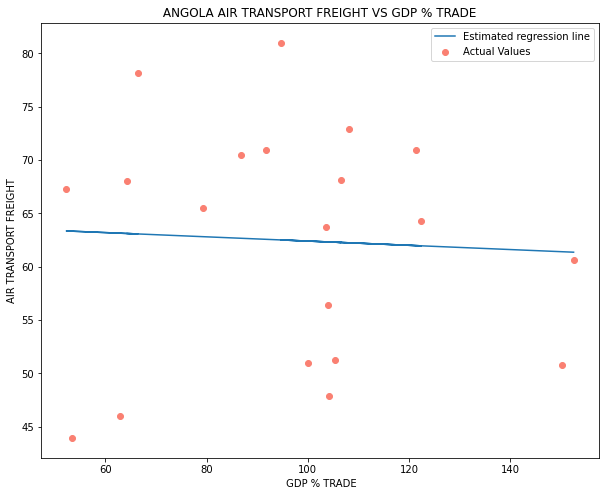

In [56]:
# H0: There isn`t a significant linear relationship(correlation)between air transport freight and  
#GDP of a country

# H1: There is a significant linear relationship(correlation) between air transport freight and
# GDP of a country

GDP = pd.read_excel("GDP_Trade.xls",sheet_name = "Data", header = None)
data_gdp = GDP.T
data_gdp.columns = data_gdp.iloc[0]
dt_gdp = data_gdp[["Country Name", "Angola"]]
dt_gdp = dt_gdp.drop(labels=[0,1,2,3], axis=0)


#air freight
AirTransport = pd.read_excel("Air_Transport.xls",sheet_name = "Data", header = None)
data_AirTransport = AirTransport.T
data_AirTransport.columns = data_AirTransport.iloc[0]
dt_Airtransport = data_AirTransport[["Country Name", "Angola"]]
dt_Airtransport = dt_Airtransport.drop(labels=[0,1,2,3], axis=0)


#merging data sets
gdp_freight = pd.merge(dt_gdp,dt_Airtransport, on  =("Country Name"))
gdp_freight = gdp_freight.rename({"Country Name":"Date","Angola_x":"Angolagdp","Angola_y":"Angolatrans"},axis ="columns")
gdp_freight.set_index("Date",inplace = True)
gdp_freight.dropna(inplace=True)
gdp_freight["Angolagdp"]= pd.to_numeric(gdp_freight["Angolagdp"])
gdp_freight["Angolatrans"]= pd.to_numeric(gdp_freight["Angolatrans"])

#correlation coefficient
corr_,y_value = pearsonr(gdp_freight.Angolagdp,gdp_freight.Angolatrans)
print("Pearsons correlation: %.3f" %corr_)
print("\n")

#reshape data 
data_x = gdp_freight.Angolagdp.to_numpy().reshape(-1,1)
data_y = gdp_freight.Angolatrans.to_numpy().reshape(-1,1)
data_t = gdp_freight.index.to_numpy().reshape(-1,1)

#2021 predictions-gdp
md_model = LinearRegression()
md_model.fit(data_t,data_x)
predict_date = "2021.0"

gdp_predict = md_model.predict(np.array([predict_date]).reshape(-1,1))

#freight prediction
lt_model = LinearRegression()
lt_model.fit(data_x,data_y)

freight_predict = lt_model.predict(np.array([gdp_predict]).reshape(-1,1))


print("2021 predicted values are GDP:",gdp_predict," Air Freight: ",freight_predict)
print("\n")

# #calculating linear regression 

slope, intercept, r_value, p_value, std_err = stats.linregress(gdp_freight.Angolagdp,gdp_freight.Angolatrans)
print("slope:",slope, "p-value",p_value ,"std_err", std_err, "intercept:", intercept,"r_value:", r_value)
print("\n")
#regression line
regression_line = (slope * gdp_freight.Angolagdp) + intercept 

alpha = 0.05

if p_value > 0.05:
    print("Reject the null hypothesis")
else:
    print("We accept the null hypothesis")




plt.scatter(gdp_freight.Angolagdp,gdp_freight.Angolatrans, color = 'salmon', label = "Actual Values")
plt.plot(gdp_freight.Angolagdp,regression_line, label = "Estimated regression line")
plt.gca().update(dict(title=" ANGOLA AIR TRANSPORT FREIGHT VS GDP % TRADE ",\
                      xlabel=" GDP % TRADE",ylabel="AIR TRANSPORT FREIGHT"))
plt.legend()
plt.show()




### Question 4

In [10]:
import quandl
import datetime

quandl.ApiConfig.api_key = "v7gDxWqnzshRriHJHxWn"
Unemployement_Rate = quandl.get("ODA/ISR_LUR", start_date = "1980-12-31", end_date = "2013-12-31")

#changing date to a number and creating an array
X = Unemployement_Rate.index.map(datetime.datetime.toordinal).to_numpy().reshape(-1,1)
Y = Unemployement_Rate.Value.to_numpy().reshape(-1,1)

#prediction date
predict_date = "2020-12-31"
predict_Date = datetime.datetime.strptime(predict_date,"%Y-%m-%d").date()
predict_number = datetime.datetime.toordinal(predict_Date)

#fitting data
clf_model = LinearRegression()
clf_model.fit(X,Y)
r_square = clf_model.score(X,Y)

#2020 unemployment prediction
future_prediction = clf_model.predict(np.array([predict_number]).reshape(-1,1))


#model acuracy using mape
def mean_absolute_percentage_error(y, y_pred): 
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100
x = X
y = Y
y_pred = clf_model.predict(x)

mape_result = mean_absolute_percentage_error(y,y_pred)

#outputs
print("Intercept:",clf_model.intercept_ ,"slope :", clf_model.coef_,"R squared:",r_square)
print("Unemployment rate prediction for 2020 is",(future_prediction))
print("The MAPE score of the model is: {:.2f}".format(mape_result),"%")

Intercept: [-221.49399182] slope : [[0.00031561]] R squared: 0.2113665859769598
Unemployment rate prediction for 2020 is [[11.36127564]]
The MAPE score of the model is: 23.71 %


Pearsons correlation: -0.051


2021 predicted values are GDP: [[49.21822527]]  Air Freight:  [[63.41110067]]
intercept: [64.38862475]
slope: [[-0.01986102]]
r_square: 0.0026358007306382936
The p value is: 8.025750923538801e-06
t_statistic =  5.1608051735029274
p-value is 8.025750923538801e-06


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


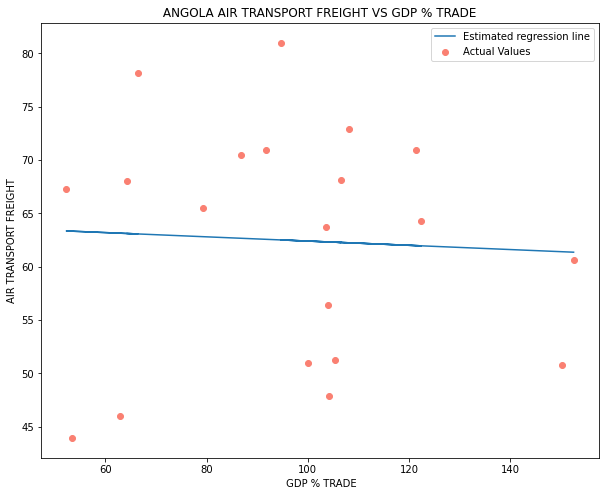

In [36]:
# H0: There isn`t a significant linear relationship(correlation)between air transport freight and  
#GDP of a country

# H1: There is a significant linear relationship(correlation) between air transport freight and
# GDP of a country

GDP = pd.read_excel("GDP_Trade.xls",sheet_name = "Data", header = None)
data_gdp = GDP.T
data_gdp.columns = data_gdp.iloc[0]
dt_gdp = data_gdp[["Country Name", "Angola"]]
dt_gdp = dt_gdp.drop(labels=[0,1,2,3], axis=0)


#air freight
AirTransport = pd.read_excel("Air_Transport.xls",sheet_name = "Data", header = None)
data_AirTransport = AirTransport.T
data_AirTransport.columns = data_AirTransport.iloc[0]
dt_Airtransport = data_AirTransport[["Country Name", "Angola"]]
dt_Airtransport = dt_Airtransport.drop(labels=[0,1,2,3], axis=0)


#merging data sets
gdp_freight = pd.merge(dt_gdp,dt_Airtransport, on  =("Country Name"))
gdp_freight = gdp_freight.rename({"Country Name":"Date","Angola_x":"Angolagdp","Angola_y":"Angolatrans"},axis ="columns")
gdp_freight.set_index("Date",inplace = True)
#gdp_freight.index = pd.to_datetime(gdp_freight.index)
gdp_freight.dropna(inplace=True)

#correlation coefficient
corr_,y_value = pearsonr(gdp_freight.Angolagdp,gdp_freight.Angolatrans)
print("Pearsons correlation: %.3f" %corr_)
print("\n")

#reshape data 
data_x = gdp_freight.Angolagdp.to_numpy().reshape(-1,1)
data_y = gdp_freight.Angolatrans.to_numpy().reshape(-1,1)
data_t = gdp_freight.index.to_numpy().reshape(-1,1)

#2021 predictions-gdp
md_model = LinearRegression()
md_model.fit(data_t,data_x)
predict_date = "2021.0"

gdp_predict = md_model.predict(np.array([predict_date]).reshape(-1,1))

#freight prediction
lt_model = LinearRegression()
lt_model.fit(data_x,data_y)

freight_predict = lt_model.predict(np.array([gdp_predict]).reshape(-1,1))
freight_predict

print("2021 predicted values are GDP:",gdp_predict," Air Freight: ",freight_predict)

# #calculating linear regression 
model_Linear = LinearRegression()
model_Linear.fit(data_x,data_y)
r_sq = model_Linear.score(data_x,data_y)

print('intercept:', model_Linear.intercept_)
print('slope:', model_Linear.coef_)
print('r_square:', r_sq)

#regression line
regression_line = model_Linear.intercept_ + np.sum(model_Linear.coef_ * data_x, axis=1)


#data_statistics
a_size = len(data_x)
b_size = (len(data_y))

a_mean = data_x.mean()
b_mean = data_y.mean()

a_std = data_x.std()
b_std = data_y.std()

alpha = 0.05

#degree of freedom
df1 = a_size - 1
df2 = b_size - 1
d_freedom = (df1 + df2)


t_value = (a_mean - b_mean) / np.sqrt(a_std**2/a_size + b_std**2/b_size)

p_value = 2*stdtr(d_freedom, -np.abs(t_value))

print("The p value is:",p_value)

print("t_statistic = ",t_value)
print("p-value is",p_value)


plt.scatter(gdp_freight.Angolagdp,gdp_freight.Angolatrans, color = 'salmon', label = "Actual Values")
plt.plot(gdp_freight.Angolagdp,regression_line, label = "Estimated regression line")
plt.gca().update(dict(title=" ANGOLA AIR TRANSPORT FREIGHT VS GDP % TRADE ",\
                      xlabel=" GDP % TRADE",ylabel="AIR TRANSPORT FREIGHT"))
plt.legend()
plt.show()




In [20]:
gdp_freight

,Angolagdp,Angolatrans
Date,,
2000.0,152.547109,60.611
2001.0,150.335795,50.818
2002.0,105.301743,51.298
2003.0,103.901227,56.455
2004.0,103.579924,63.692
2005.0,106.590962,68.112
2006.0,94.625159,80.997
2007.0,108.060068,72.888
2008.0,121.364708,70.934
